pip install --upgrade scikit-image

pip show scikit-image

### Data Preparation

##### Loding Libraries

essential libraries for image processing, data manipulation, visualization, and machine learning are imported.

In [1]:
from tqdm import tqdm
import numpy as np # linear algebra
import tensorflow as tf # for tensorflow based registration
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from skimage.util.montage import montage2d
import os
from cv2 import imread, createCLAHE # read and equalize images
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### Loading Image Paths

It collects paths for images and their corresponding masks, creating pairs in cxr_images list.

In [6]:
cxr_paths = glob(os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities',
                              'Montgomery', 'MontgomerySet','*','*.png'))


In [7]:
cxr_images = [(c_path, 
               [os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','leftMask', os.path.basename(c_path)),
               os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','rightMask', os.path.basename(c_path))]
              ) for c_path in cxr_paths]


##### Image Processing Func

Defines a function imread to read and preprocess images by resizing them to OUT_DIM and applying CLAHE if needed.

In [8]:
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage') # skimage is really annoying
OUT_DIM = (512, 512)
def imread(in_path, apply_clahe = False):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    return np.expand_dims(n_img, -1)

### Visualization:

##### Displaying Sample Images

Prints the count of loaded images, paths

In [9]:
print('CXR Images', len(cxr_paths), cxr_paths[0])

CXR Images 138 ../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0017_0.png


In [10]:
print(cxr_images[0])

('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0017_0.png', ['../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0017_0.png', '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0017_0.png'])


displays a sample image along with its shape

In [11]:
cv2.imread(cxr_images[40][0]).shape

(4892, 4020, 3)

In [12]:
image=cv2.imread(cxr_images[40][0])
cv2.imwrite('Sample_Image.png', image)

True

##### Data Segmentation Process

Data Volume Initialization

In [13]:
img_vol, seg_vol = [], []
for img_path, s_paths in tqdm(cxr_images):
    img_vol += [imread(img_path)]    
    seg_vol += [np.max(np.stack([imread(s_path, apply_clahe = False) for s_path in s_paths],0),0)]

100%|██████████| 138/138 [03:27<00:00,  1.51s/it]


Stacking Image and Segmentation Volumes

In [14]:
img_vol = np.stack(img_vol,0)
seg_vol = np.stack(seg_vol,0)

Output and Shape Information

In [15]:
print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

Images (138, 512, 512, 1) Segmentations (138, 512, 512, 1)


##### Visualizing Images and Masks

Plots a sample image and its corresponding mask side by side

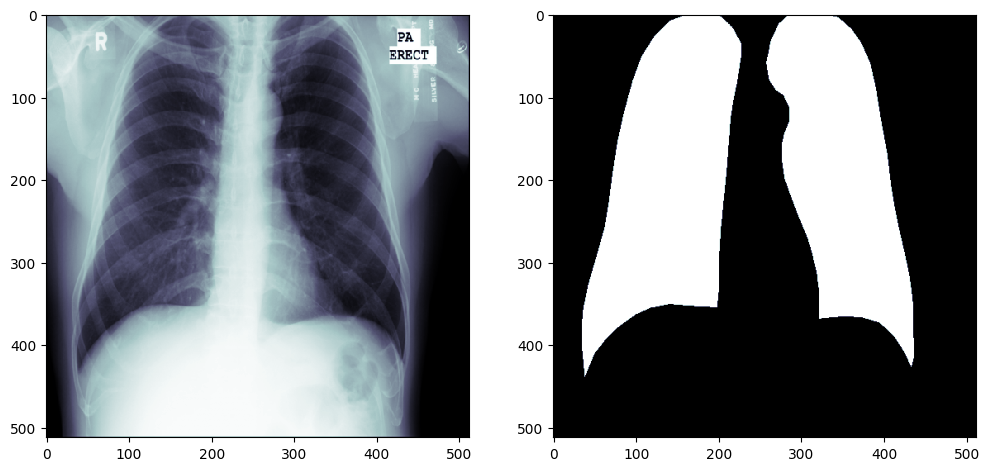

In [16]:
np.random.seed(2018)
t_img, m_img = img_vol[2], seg_vol[2]

fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(np.clip(255*t_img, 0, 255).astype(np.uint8) if t_img.shape[2]==3 else t_img[:,:,0],
              interpolation = 'none', cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

##### Random Selection of Indices

visualize random images and their corresponding masks

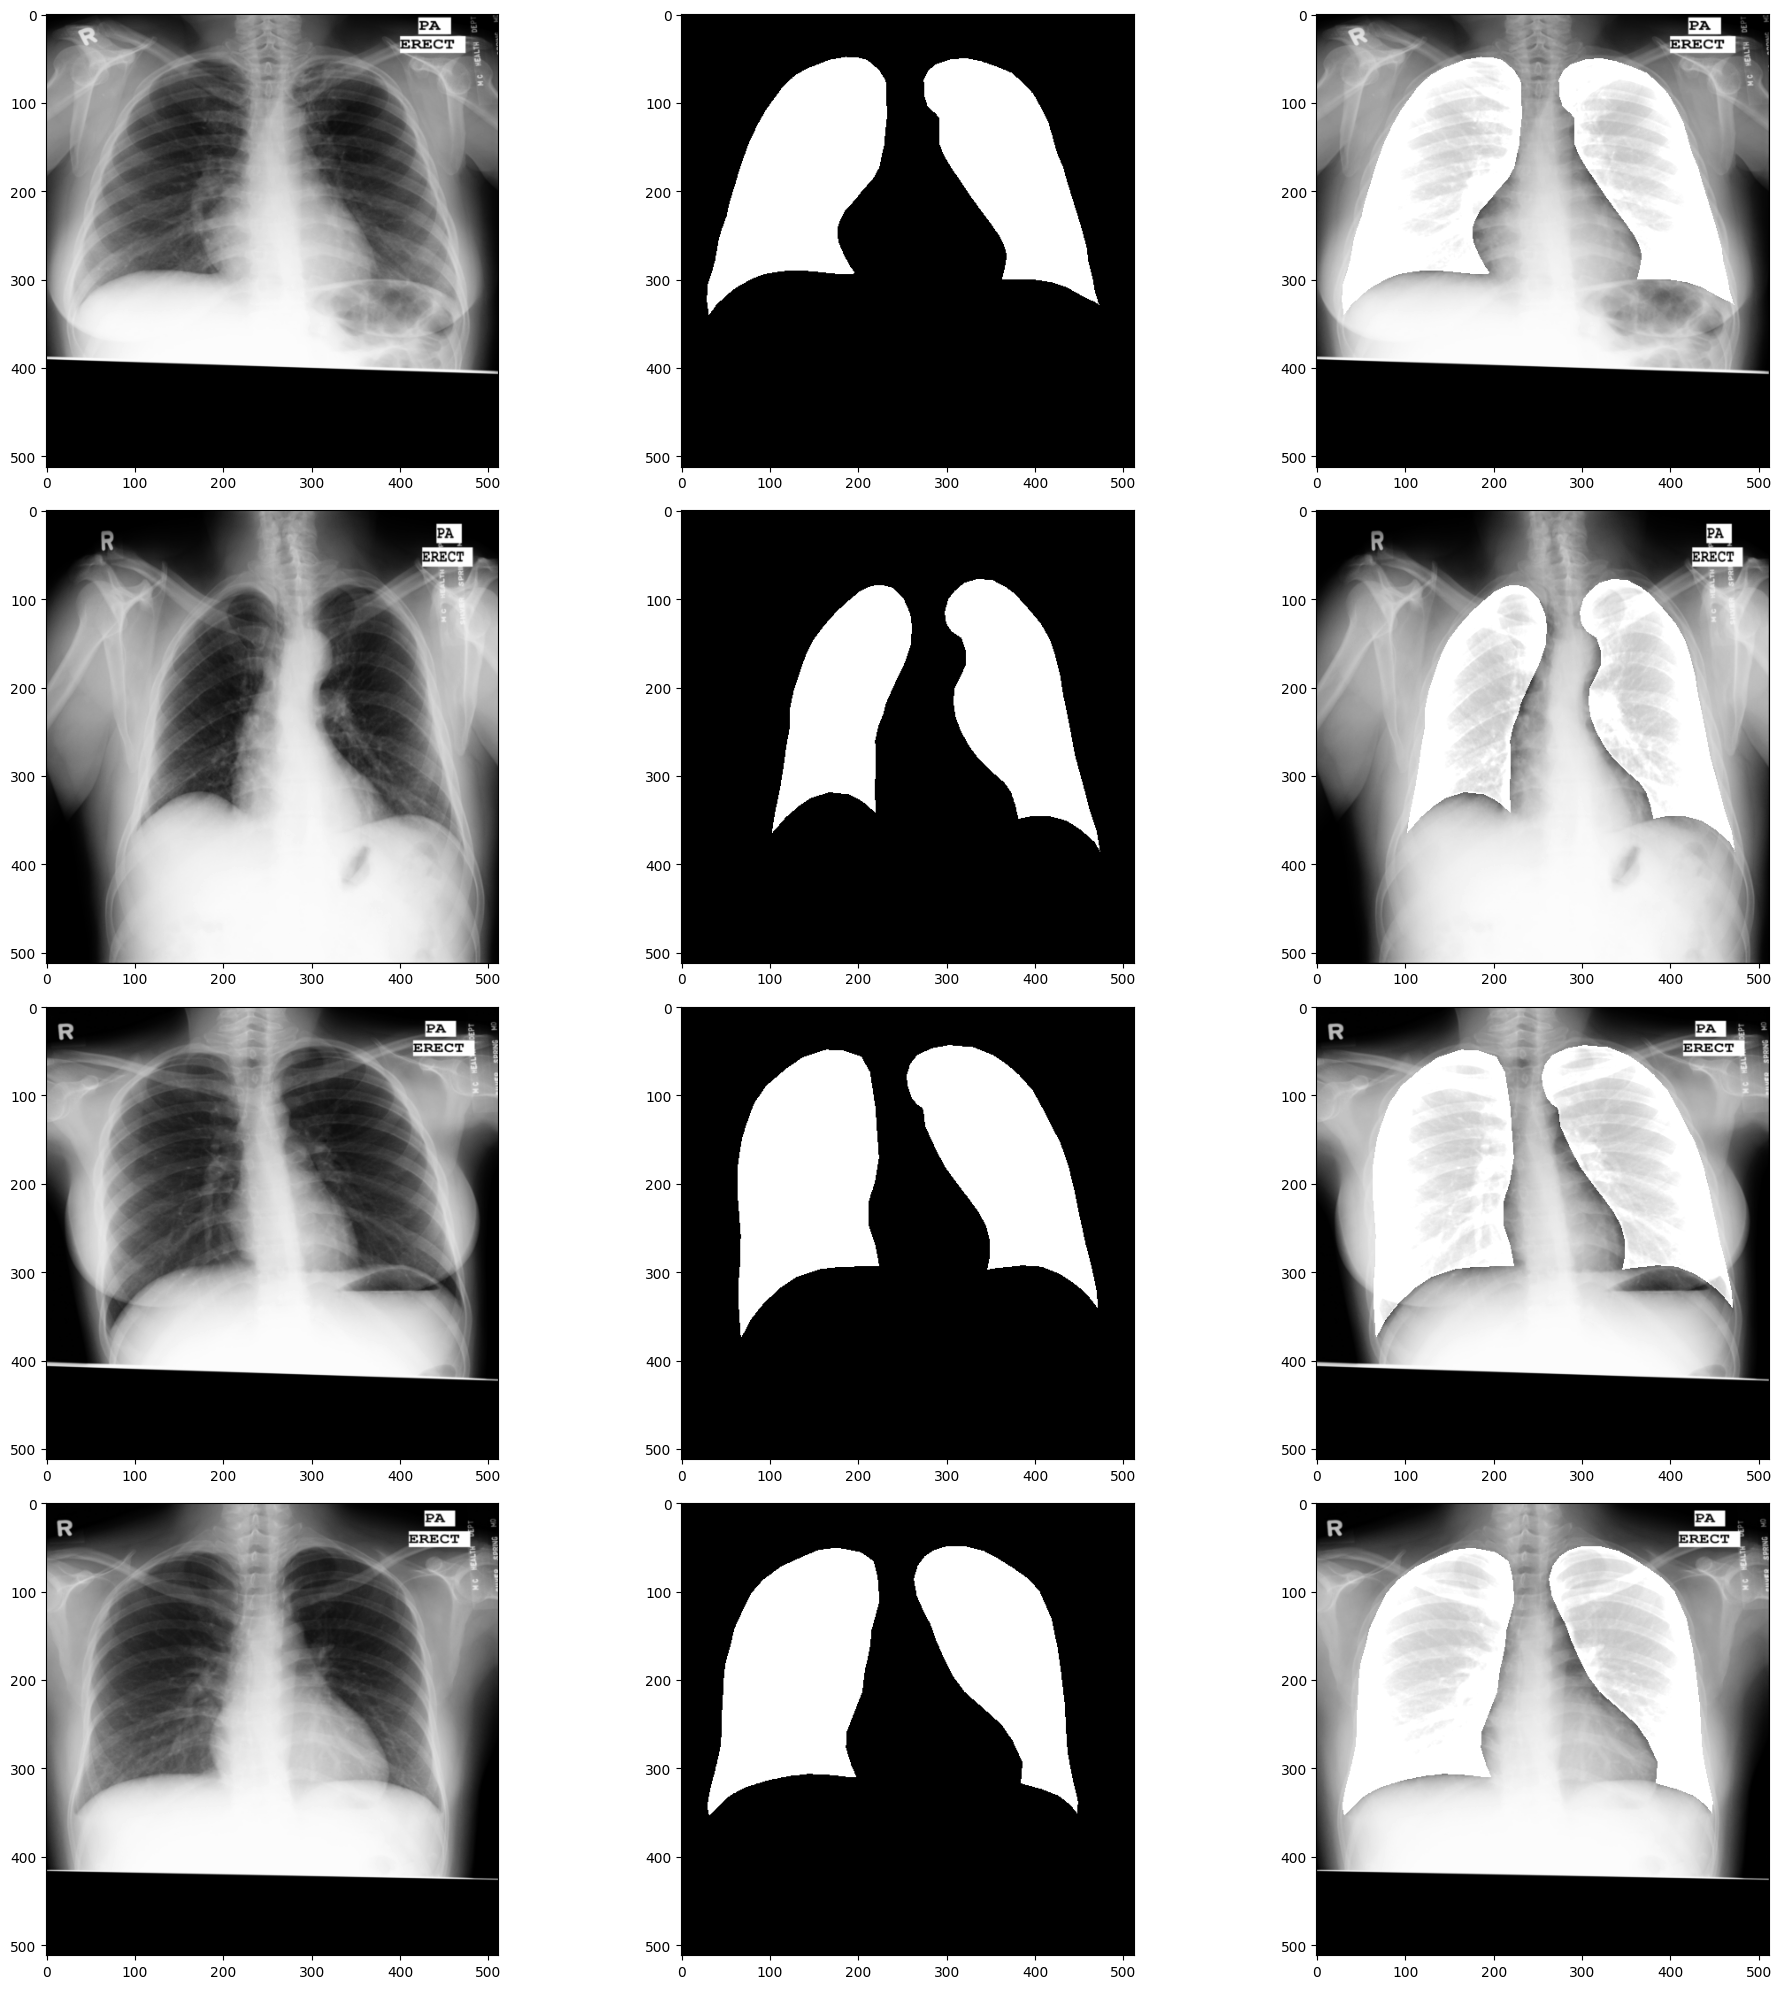

In [17]:
def random_plot(images, masks, number):
    indices = np.random.choice(len(images), number)
    fig, axis = plt.subplots(nrows=number, ncols=3, figsize=(20, 20))

    for i, index in enumerate(indices):
        img = images[index]
        mask = masks[index]

        axis[i][0].imshow(img, cmap='gray')
        axis[i][1].imshow(mask, cmap='gray')
        axis[i][2].imshow(cv2.addWeighted(img, 1.0, mask, 0.7, 1), cmap='gray')

    plt.tight_layout()
    
random_plot(img_vol, seg_vol , 4)

### Data Splitting

Prints out information about the training and testing data shapes, mean value, maximum value, and unique values present in the segmentation training set.

Train (110, 512, 512, 1) Test (28, 512, 512, 1) -0.14738946878199366 1.0078740157480315
Seg (110, 512, 512, 1) 1.0 [0. 1.]


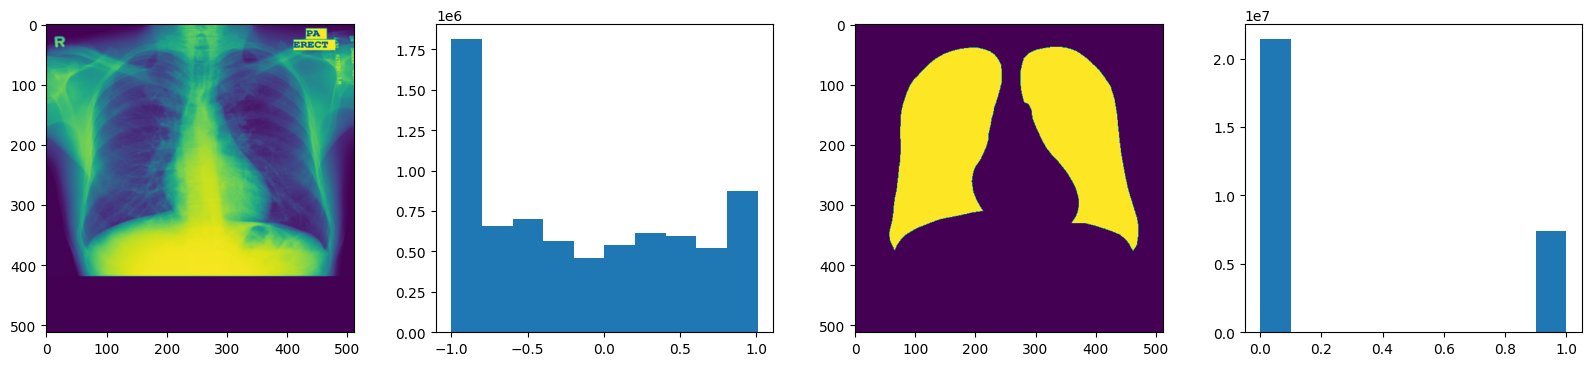

In [18]:
from sklearn.model_selection import train_test_split
train_vol, test_vol, train_seg, test_seg = train_test_split((img_vol-127.0)/127.0, 
                                                            (seg_vol>127).astype(np.float32), 
                                                            test_size = 0.2, 
                                                            random_state = 2018)
print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0]>0.5)
ax2hist.hist(train_seg.ravel());

### Image Data Augmentation

dg_args contains various augmentation configurations (like rotation, shifting, flipping, etc.) specified as a dictionary of arguments.

In [19]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
                  horizontal_flip = True,  
                  vertical_flip = False,
                  fill_mode = 'nearest',
               data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

#### Generating Augmented Data Pairs

gen_augmented_pairs is a generator function to create augmented pairs of input volume data (in_vol) and segmentation data (in_seg) in batches.
yield i_vol, i_seg returns a batch of augmented input volume and segmentation data pairs.

In [20]:
def gen_augmented_pairs(in_vol, in_seg, batch_size = 16):
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_vol = image_gen.flow(in_vol, batch_size = batch_size, seed = seed)
        g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
        for i_vol, i_seg in zip(g_vol, g_seg):
            yield i_vol, i_seg
            

##### Data Generation and Visualization

In [21]:
train_gen = gen_augmented_pairs(train_vol, train_seg, batch_size = 16)
test_gen = gen_augmented_pairs(test_vol, test_seg, batch_size = 16)
train_X, train_Y = next(train_gen)
test_X, test_Y = next(test_gen)
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(16, 512, 512, 1) (16, 512, 512, 1)
(16, 512, 512, 1) (16, 512, 512, 1)


##### Visualization of Augmented Data

In [22]:
from skimage.util import montage as montage2d

Text(0.5, 1.0, 'Seg Image')

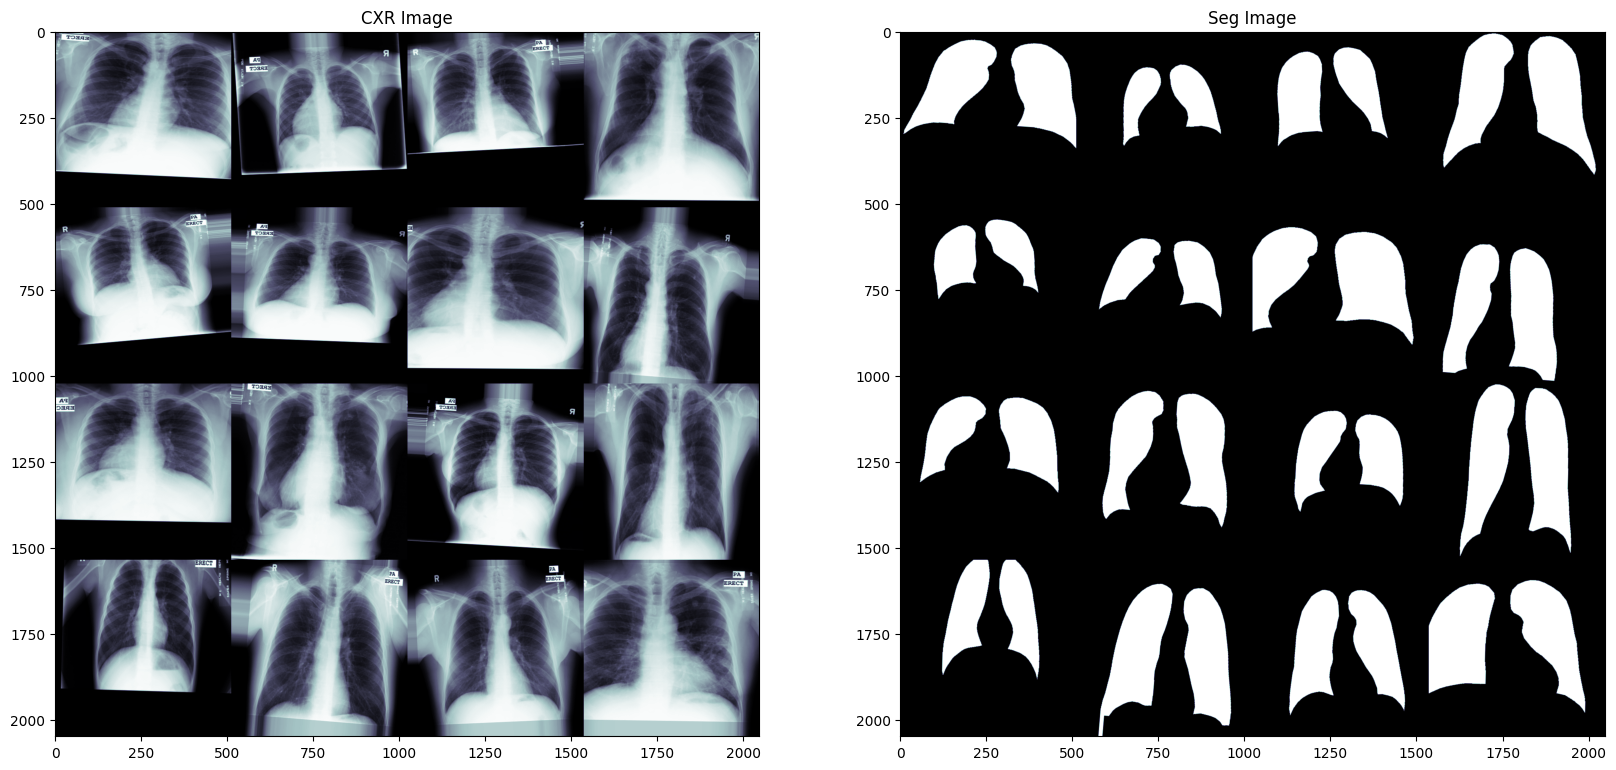

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(train_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(train_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')

### Custom Evaluation Metrics Definition


prepares the code for training by compiling it with appropriate optimization parameters and evaluation metrics.


In [24]:
from keras.optimizers import Adam
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import numpy as np
from keras import backend as K

In [25]:
reg_param = 1.0
lr = 1e-4 # (e.g., 1e-4 or 5e-4).
dice_bce_param = 1.0
use_dice = True

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return dice_bce_param*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

def mean_iou(y_true, y_pred):
    def iou(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
        iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
        return iou
    return K.mean(iou(y_true, y_pred))

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

### U-Net Model 1

##### import Libraries

In [22]:
from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal

##### Encoder

Defines convolutional layer c2 and an encoder function unet_enc to create the U-Net encoder part.

c2: A helper function that represents a convolutional block with Conv2D and LeakyReLU activation.
unet_enc: Defines the encoder part of the U-Net architecture using the previously defined c2 blocks.

Regularization Techniques: Introduce regularization techniques like dropout, batch normalization, or L1/L2 regularization to prevent overfitting.

In [23]:
def c2(x_in, nf, strides=1):
    x_out = Conv2D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out
def unet_enc(vol_size, enc_nf, pre_filter = 8):
    src = Input(shape=vol_size + (1,), name = 'EncoderInput')
    # down-sample path.
    x_in = BatchNormalization(name = 'NormalizeInput')(src)
    x_in = c2(x_in, pre_filter, 1)
    x0 = c2(x_in, enc_nf[0], 2)  
    x1 = c2(x0, enc_nf[1], 2)  
    x2 = c2(x1, enc_nf[2], 2)  
    x3 = c2(x2, enc_nf[3], 2) 
    return Model(inputs = [src], 
                outputs = [x_in, x0, x1, x2, x3],
                name = 'UnetEncoder')

##### U-Net Model

Defines the complete U-Net architecture by connecting the encoder and decoder parts.

unet: Combines the encoder and decoder parts of the U-Net.
Uses c2 blocks, UpSampling2D, and concatenation to build the decoder part.
Defines the final output layer for semantic segmentation.

In [24]:
from keras.models import Model
from keras import layers
def unet(vol_size, enc_nf, dec_nf, full_size=True, edge_crop=48):
    #U-Net Model Layers
        raw_src = Input(shape=vol_size + (1,), name = 'ImageInput')
        src = layers.GaussianNoise(0.25)(raw_src)
        enc_model = unet_enc(vol_size, enc_nf)
        # run the same encoder on the source and the target and concatenate the output at each level
        x_in, x0, x1, x2, x3 = [s_enc for s_enc in enc_model(src)]

        x = c2(x3, dec_nf[0])
        x = UpSampling2D()(x)
        x = concatenate([x, x2])
        
        x = c2(x, dec_nf[1])
        x = UpSampling2D()(x)
        x = concatenate([x, x1])
        
        x = c2(x, dec_nf[2])
        x = UpSampling2D()(x)
        x = concatenate([x, x0])
        
        x = c2(x, dec_nf[3])
        x = c2(x, dec_nf[4])
        x = UpSampling2D()(x)
        x = concatenate([x, x_in])
        x = c2(x, dec_nf[5])    
        
        y_seg = Conv2D(1, kernel_size=3, padding='same', name='lungs', activation='sigmoid')(x)
        y_seg = layers.Cropping2D((edge_crop, edge_crop))(y_seg)
        y_seg = layers.ZeroPadding2D((edge_crop, edge_crop))(y_seg)
        # prepare model
        model = Model(inputs=[raw_src], outputs=[y_seg])
        return model

### Model Compilation with Custom Metrics

##### Model Evaluation on Test Data

Evaluates the model's performance on the test data and prints the test loss, accuracy, and other metrics depending on the defined model metrics.

#### MODEL - 1a|

Loss Function: binary_crossentropy
Metrics: 
inbuilt - accuracy, mae (Mean Absolute Error), mse (Mean Squared Error), custom functions - dice_coef, mean_iou, precision, recall, f1_score.

In [25]:
# Specify the volume size, encoder and decoder channels
vol_size = (512, 512)
enc_nf = [32, 64, 128, 256, 512]
dec_nf = [512, 256, 128, 64, 32, 32]


In [26]:
model = unet(vol_size, enc_nf, dec_nf)
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[true_positive_rate, 'binary_accuracy','accuracy','mae','mse',dice_coef, mean_iou, precision, recall, f1_score])
#model.fit(train_X, train_Y, batch_size=16, epochs=,validation_data=(test_X, test_Y))

model.fit(train_X, train_Y, batch_size=16, epochs=25,validation_data=(test_X, test_Y))
model.summary()



Epoch 1/25
1/1 [==============================] - 25s 25s/step - loss: 0.9482 - true_positive_rate: 6.9835e-04 - binary_accuracy: 0.7555 - accuracy: 0.7555 - mae: 0.2360 - mse: 0.2060 - dice_coef: 0.1439 - mean_iou: 0.0778 - precision: 0.7221 - recall: 6.9170e-04 - f1_score: 0.0014 - val_loss: 4.2223 - val_true_positive_rate: 0.9129 - val_binary_accuracy: 0.5460 - val_accuracy: 0.5460 - val_mae: 0.4475 - val_mse: 0.4417 - val_dice_coef: 0.4969 - val_mean_iou: 0.3397 - val_precision: 0.3516 - val_recall: 0.9128 - val_f1_score: 0.5076
Epoch 2/25
1/1 [==============================] - 1s 525ms/step - loss: 5.0484 - true_positive_rate: 0.9351 - binary_accuracy: 0.5457 - accuracy: 0.5457 - mae: 0.4504 - mse: 0.4490 - dice_coef: 0.4918 - mean_iou: 0.3324 - precision: 0.3413 - recall: 0.9351 - f1_score: 0.5001 - val_loss: 3.4871 - val_true_positive_rate: 0.0000e+00 - val_binary_accuracy: 0.7419 - val_accuracy: 0.7419 - val_mae: 0.2564 - val_mse: 0.2523 - val_dice_coef: 0.0031 - val_mean_iou: 

In [27]:
scores = model.evaluate(test_X, test_Y)

1/1 [==============================] - 1s 718ms/step - loss: 0.6998 - true_positive_rate: 0.2877 - binary_accuracy: 0.7292 - accuracy: 0.7292 - mae: 0.2628 - mse: 0.1482 - dice_coef: 0.4185 - mean_iou: 0.2688 - precision: 0.4597 - recall: 0.2875 - f1_score: 0.3537


In [28]:
print("Loss:", scores[0])
print("True Positive Rate:", scores[1])
print("Binary Accuracy:", scores[2])
print("Accuracy:",scores[3])
print("MAE:", scores[4])
print("MSE:", scores[5])
print("Dice Coefficient':",scores[6])
print("Mean IoU:", scores[7])
print("Precision:", scores[8])
print("Recall:", scores[9])
print("F1 Score:", scores[10])

Loss: 0.6998148560523987
True Positive Rate: 0.28770461678504944
Binary Accuracy: 0.7292048931121826
Accuracy: 0.7292048931121826
MAE: 0.26278501749038696
MSE: 0.1482437252998352
Dice Coefficient': 0.4185448884963989
Mean IoU: 0.2687769830226898
Precision: 0.45971688628196716
Recall: 0.28748229146003723
F1 Score: 0.3537489175796509


#### MODEL - 1b

Loss Function: dice_p_bce (a custom-defined loss function) -- a combination of dice coefficient and binary cross-entropy.

Metrics: 
custom functions - true_positive_rate, 
inbuilt -'binary_accuracy'

In [29]:
print(OUT_DIM)

(512, 512)


In [45]:
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,2]
net = unet(OUT_DIM, nf_enc, nf_dec)
a= net.predict([np.zeros((1,)+OUT_DIM+(1,))])
print(a.shape)
net.compile(optimizer=Adam(lr=lr), 
              loss=[dice_p_bce], 
           metrics = [true_positive_rate, 'binary_accuracy','accuracy',
                      'mae','mse',dice_coef, mean_iou, precision, recall, f1_score])

net.fit(train_X, train_Y, batch_size=16, epochs=5, validation_data=(test_X, test_Y))
net.summary()

1/1 [==============================] - 0s 184ms/step
(1, 512, 512, 1)
Epoch 1/5
1/1 [==============================] - 6s 6s/step - loss: 0.4953 - true_positive_rate: 0.7266 - binary_accuracy: 0.5583 - accuracy: 0.5583 - mae: 0.3971 - mse: 0.2563 - dice_coef: 0.3894 - mean_iou: 0.2440 - precision: 0.3175 - recall: 0.7210 - f1_score: 0.4409 - val_loss: 0.3458 - val_true_positive_rate: 0.0049 - val_binary_accuracy: 0.7411 - val_accuracy: 0.7411 - val_mae: 0.2960 - val_mse: 0.1500 - val_dice_coef: 0.3753 - val_mean_iou: 0.2329 - val_precision: 0.3738 - val_recall: 0.0048 - val_f1_score: 0.0095
Epoch 2/5
1/1 [==============================] - 0s 281ms/step - loss: 0.1905 - true_positive_rate: 0.1450 - binary_accuracy: 0.7761 - accuracy: 0.7761 - mae: 0.2604 - mse: 0.1327 - dice_coef: 0.3994 - mean_iou: 0.2508 - precision: 0.7076 - recall: 0.1441 - f1_score: 0.2395 - val_loss: 0.2400 - val_true_positive_rate: 0.7104 - val_binary_accuracy: 0.7828 - val_accuracy: 0.7828 - val_mae: 0.2781 - va

In [31]:
scores1 = net.evaluate(test_X, test_Y)

1/1 [==============================] - 1s 605ms/step - loss: 1.1154 - true_positive_rate: 0.0326 - binary_accuracy: 0.7478 - accuracy: 0.7478 - mae: 0.2549 - mse: 0.2180 - dice_coef: 0.1551 - mean_iou: 0.0849 - precision: 0.7694 - recall: 0.0323 - f1_score: 0.0621


In [32]:
print(scores1)

[1.115377426147461, 0.03264026343822479, 0.7478106021881104, 0.7478106021881104, 0.25488996505737305, 0.21801771223545074, 0.1550597846508026, 0.08489818871021271, 0.7694212198257446, 0.03234850987792015, 0.062086716294288635]


In [33]:
print("Loss:", scores1[0])
print("True Positive Rate:", scores1[1])
print("Binary Accuracy:", scores1[2])
print("Accuracy:",scores1[3])
print("MAE:", scores1[4])
print("MSE:", scores1[5])
print("Dice Coefficient:",scores1[6])
print("Mean IoU:", scores1[7])
print("Precision:", scores1[8])
print("Recall:", scores1[9])
print("F1 Score:", scores1[10])

Loss: 1.115377426147461
True Positive Rate: 0.03264026343822479
Binary Accuracy: 0.7478106021881104
Accuracy: 0.7478106021881104
MAE: 0.25488996505737305
MSE: 0.21801771223545074
Dice Coefficient: 0.1550597846508026
Mean IoU: 0.08489818871021271
Precision: 0.7694212198257446
Recall: 0.03234850987792015
F1 Score: 0.062086716294288635


#### MODEL - 1c

In [34]:
input_size = (512,512)
nf_enc1=[64, 128, 256, 512]
nf_dec1=[256, 128, 64, 32, 16, 8]
model3 = unet(input_size, nf_enc1, nf_dec1)
a= model3.predict([np.zeros((1,)+(512,512)+(1,))])
print(a.shape)

1/1 [==============================] - 1s 512ms/step
(1, 512, 512, 1)


In [35]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ImageInput (InputLayer)     [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 gaussian_noise_2 (Gaussian  (None, 512, 512, 1)          0         ['ImageInput[0][0]']          
 Noise)                                                                                           
                                                                                                  
 UnetEncoder (Functional)    [(None, 512, 512, 8),        1553940   ['gaussian_noise_2[0][0]']    
                              (None, 256, 256, 64),                                               
                              (None, 128, 128, 128),                                        

In [46]:
model3.compile(optimizer=Adam(lr=5e-4), 
              loss=[dice_p_bce], 
           metrics = [true_positive_rate, 'binary_accuracy','accuracy',
                      'mae','mse',dice_coef, mean_iou, precision, recall, f1_score])

model3.fit(train_X, train_Y, batch_size=16, epochs=5, validation_data=(test_X, test_Y))

Epoch 1/5
1/1 [==============================] - 6s 6s/step - loss: -0.6182 - true_positive_rate: 0.8840 - binary_accuracy: 0.9610 - accuracy: 0.9610 - mae: 0.0385 - mse: 0.0296 - dice_coef: 0.9163 - mean_iou: 0.8469 - precision: 0.9668 - recall: 0.8831 - f1_score: 0.9230 - val_loss: 3.7466 - val_true_positive_rate: 0.2679 - val_binary_accuracy: 0.5787 - val_accuracy: 0.5787 - val_mae: 0.4127 - val_mse: 0.3963 - val_dice_coef: 0.2323 - val_mean_iou: 0.1346 - val_precision: 0.2266 - val_recall: 0.2669 - val_f1_score: 0.2451
Epoch 2/5
1/1 [==============================] - 0s 411ms/step - loss: 4.9240 - true_positive_rate: 0.9351 - binary_accuracy: 0.5499 - accuracy: 0.5499 - mae: 0.4423 - mse: 0.4363 - dice_coef: 0.4960 - mean_iou: 0.3361 - precision: 0.3434 - recall: 0.9351 - f1_score: 0.5024 - val_loss: 3.6818 - val_true_positive_rate: 0.0058 - val_binary_accuracy: 0.7432 - val_accuracy: 0.7432 - val_mae: 0.2527 - val_mse: 0.2509 - val_dice_coef: 0.0134 - val_mean_iou: 0.0069 - val_pr

In [37]:
scores2 = net.evaluate(test_X, test_Y)

1/1 [==============================] - 0s 99ms/step - loss: 1.1154 - true_positive_rate: 0.0326 - binary_accuracy: 0.7478 - accuracy: 0.7478 - mae: 0.2549 - mse: 0.2180 - dice_coef: 0.1551 - mean_iou: 0.0849 - precision: 0.7694 - recall: 0.0323 - f1_score: 0.0621


In [38]:
print("Loss:", scores2[0])
print("True Positive Rate:", scores2[1])
print("Binary Accuracy:", scores2[2])
print("Accuracy:",scores2[3])
print("MAE:", scores2[4])
print("MSE:", scores2[5])
print("Dice Coefficient:",scores2[6])
print("Mean IoU:", scores2[7])
print("Precision:", scores2[8])
print("Recall:", scores2[9])
print("F1 Score:", scores2[10])

Loss: 1.115377426147461
True Positive Rate: 0.03264026343822479
Binary Accuracy: 0.7478106021881104
Accuracy: 0.7478106021881104
MAE: 0.25488996505737305
MSE: 0.21801771223545074
Dice Coefficient: 0.1550597846508026
Mean IoU: 0.08489818871021271
Precision: 0.7694212198257446
Recall: 0.03234850987792015
F1 Score: 0.062086716294288635


### U-Net Model 2

In [26]:
from keras.models import Model
from keras.layers import Conv2DTranspose,Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate

def custom_unet(vol_size, enc_nf, dec_nf, full_size=True, edge_crop=48):
    # Encoder function
    def encoder_block(x, filters, kernel_size=(3, 3), activation='relu'):
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x

    # Decoder function
    def decoder_block(x, filters, kernel_size=(3, 3), activation='relu'):
        x = Conv2DTranspose(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x

    # Input layer
    inputs = Input(shape=vol_size + (1,), name='Input')

    # Encoder
    conv1 = encoder_block(inputs, enc_nf[0])
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = encoder_block(pool1, enc_nf[1])
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = encoder_block(pool2, enc_nf[2])
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = encoder_block(pool3, enc_nf[3])
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = encoder_block(pool4, enc_nf[4])

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    concat6 = Concatenate()([up6, conv4])
    conv6 = decoder_block(concat6, dec_nf[0])

    up7 = UpSampling2D(size=(2, 2))(conv6)
    concat7 = Concatenate()([up7, conv3])
    conv7 = decoder_block(concat7, dec_nf[1])

    up8 = UpSampling2D(size=(2, 2))(conv7)
    concat8 = Concatenate()([up8, conv2])
    conv8 = decoder_block(concat8, dec_nf[2])

    up9 = UpSampling2D(size=(2, 2))(conv8)
    concat9 = Concatenate()([up9, conv1])
    conv9 = decoder_block(concat9, dec_nf[3])

    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # Model
    model = Model(inputs=[inputs], outputs=[output], name='CustomUNet')
    return model

##### Model - 2a

In [27]:
enc_filters = [32, 64, 128, 256, 512]
dec_filters = [256, 128, 64, 32]
unet_model2 = custom_unet((512,512), enc_nf=enc_filters, dec_nf=dec_filters)

In [28]:
b= unet_model2.predict([np.zeros((1,)+(512,512)+(1,))])
print(b.shape)

1/1 [==============================] - 8s 8s/step
(1, 512, 512, 1)


In [29]:
unet_model2.compile(optimizer='adam', loss='mse',
                   metrics=[true_positive_rate,'binary_accuracy', 'accuracy', 'mae','mse',dice_coef,mean_iou,  precision, recall, f1_score])

In [30]:
unet_model2.fit(train_X, train_Y, batch_size=16, epochs=50, validation_data=(test_X, test_Y))
scores_2 = unet_model2.evaluate(test_X, test_Y)

Epoch 1/50
1/1 [==============================] - 21s 21s/step - loss: 0.2042 - true_positive_rate: 0.3414 - binary_accuracy: 0.6589 - accuracy: 0.6589 - mae: 0.4219 - mse: 0.2042 - dice_coef: 0.3362 - mean_iou: 0.2035 - precision: 0.3104 - recall: 0.3361 - f1_score: 0.3228 - val_loss: 0.2241 - val_true_positive_rate: 2.8366e-04 - val_binary_accuracy: 0.7418 - val_accuracy: 0.7418 - val_mae: 0.4695 - val_mse: 0.2241 - val_dice_coef: 0.3199 - val_mean_iou: 0.1924 - val_precision: 0.2583 - val_recall: 2.5600e-04 - val_f1_score: 5.1149e-04
Epoch 2/50
1/1 [==============================] - 1s 632ms/step - loss: 0.1284 - true_positive_rate: 0.9375 - binary_accuracy: 0.8236 - accuracy: 0.8236 - mae: 0.2872 - mse: 0.1284 - dice_coef: 0.5372 - mean_iou: 0.3716 - precision: 0.5871 - recall: 0.9343 - f1_score: 0.7211 - val_loss: 0.2236 - val_true_positive_rate: 0.0098 - val_binary_accuracy: 0.7341 - val_accuracy: 0.7341 - val_mae: 0.4677 - val_mse: 0.2236 - val_dice_coef: 0.3172 - val_mean_iou: 

In [31]:
print("Loss:", scores_2[0])
print("True Positive Rate:", scores_2[1])
print("Binary Accuracy:", scores_2[2])
print("Accuracy:",scores_2[3])
print("MAE:", scores_2[4])
print("MSE:", scores_2[5])
print("Dice Coefficient:",scores_2[6])
print("Mean IoU:", scores_2[7])
print("Precision:", scores_2[8])
print("Recall:", scores_2[9])
print("F1 Score:", scores_2[10])

Loss: 0.17184439301490784
True Positive Rate: 0.0
Binary Accuracy: 0.7418994903564453
Accuracy: 0.7418994903564453
MAE: 0.3636071979999542
MSE: 0.17184439301490784
Dice Coefficient: 0.2856179475784302
Mean IoU: 0.16749799251556396
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


##### Model - 2b

In [32]:
enc_filtersb = [64, 128, 256, 512, 1024]
dec_filtersb = [512, 256, 128, 64]
unet_model2b = custom_unet((512,512), enc_nf=enc_filtersb, dec_nf=dec_filtersb)

In [33]:
bb= unet_model2b.predict([np.zeros((1,)+(512,512)+(1,))])
print(bb.shape)

1/1 [==============================] - 1s 1s/step
(1, 512, 512, 1)


In [34]:
unet_model2b.compile(optimizer=Adam(learning_rate=0.001), loss=dice_p_bce,
                   metrics=[true_positive_rate,'binary_accuracy', 'accuracy', 'mae','mse',dice_coef,mean_iou,  precision, recall, f1_score])

In [35]:
import tensorflow.keras.backend as K

# Reset TensorFlow session
K.clear_session()
import keras.backend as K
K.clear_session()


In [36]:
unet_model2b.fit(train_X, train_Y, batch_size=8,epochs=10,validation_data=(test_X ,test_Y))
scores_2b = unet_model2b.evaluate(test_X, test_Y)

Epoch 1/50
2/2 [==============================] - 25s 2s/step - loss: 0.1688 - true_positive_rate: 0.6110 - binary_accuracy: 0.6489 - accuracy: 0.6489 - mae: 0.3771 - mse: 0.2090 - dice_coef: 0.4307 - mean_iou: 0.2913 - precision: 0.3431 - recall: 0.6086 - f1_score: 0.4382 - val_loss: 0.2266 - val_true_positive_rate: 1.1911e-05 - val_binary_accuracy: 0.7400 - val_accuracy: 0.7400 - val_mae: 0.3446 - val_mse: 0.1733 - val_dice_coef: 0.2896 - val_mean_iou: 0.1703 - val_precision: 0.0014 - val_recall: 9.9105e-06 - val_f1_score: 1.9677e-05
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: -0.2635 - true_positive_rate: 0.8562 - binary_accuracy: 0.8472 - accuracy: 0.8472 - mae: 0.2110 - mse: 0.1093 - dice_coef: 0.6258 - mean_iou: 0.4599 - precision: 0.6419 - recall: 0.8542 - f1_score: 0.7320 - val_loss: 0.8561 - val_true_positive_rate: 0.0023 - val_binary_accuracy: 0.7361 - val_accuracy: 0.7361 - val_mae: 0.2825 - val_mse: 0.2315 - val_dice_coef: 0.1110 - val_mean_iou: 0.0

In [37]:
print("Loss:", scores_2b[0])
print("True Positive Rate:", scores_2b[1])
print("Binary Accuracy:", scores_2b[2])
print("Accuracy:",scores_2b[3])
print("MAE:", scores_2b[4])
print("MSE:", scores_2b[5])
print("Dice Coefficient:",scores_2b[6])
print("Mean IoU:", scores_2b[7])
print("Precision:", scores_2b[8])
print("Recall:", scores_2b[9])
print("F1 Score:", scores_2b[10])

Loss: 1.5392323732376099
True Positive Rate: 0.0
Binary Accuracy: 0.738088846206665
Accuracy: 0.738088846206665
MAE: 0.26121756434440613
MSE: 0.2549131214618683
Dice Coefficient: 0.005369909573346376
Mean IoU: 0.0026842295192182064
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
